In [69]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [70]:
import numpy as np 
import scipy
from operators.setup_ROM import SimulationSetupROM
from operators.poisson_solver import gmres_solver
from operators.FOM import psi_ln_aw, charge_density
from operators.FOM import total_mass, total_momentum, total_energy_k

In [71]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# weak Landau damping ROM

In [81]:
setup = SimulationSetupROM(Nx=151,
                           Nv=50,
                           epsilon=1e-2,
                           alpha_e=0.75,
                           alpha_i=np.sqrt(2 / 1836),
                           u_e=0,
                           u_i=0,
                           L=2 * np.pi,
                           dt=1e-2,
                           T0=0,
                           T=80,
                           nu=10,
                           Nr=50,
                           M=3,
                           problem_dir="weak_landau",
                           Ur_e=np.load("../data/ROM/weak_landau/basis_50/basis_3.npy"),
                           construct=False,
                           load=False,
                           ions=False)

In [82]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [83]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(1e4))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx + 1)

# ROM simulation data

In [84]:
# load the simulation results
sol_u_reduced = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_ROM_u_" + str(setup.Nr) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_ROM_t_" + str(setup.Nr) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

In [85]:
# project back up the reduced simulation results
sol_u_ROM = np.zeros((setup.Nx*setup.Nv, len(sol_midpoint_t)))
sol_u_ROM[:setup.NF, :] = sol_u_reduced[:setup.NF, :]
sol_u_ROM[setup.NF:, :] = setup.Ur_e @ sol_u_reduced[setup.NF:, :]

In [86]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

# unwind the flattening to solve the Vlasov-Poisson system
# electrons
state_e_midpoint[:, :-1, :] = np.reshape(sol_u_ROM, (setup.Nv, setup.Nx, len(sol_midpoint_t)))
state_e_midpoint[:, -1, :] = state_e_midpoint[:, 0, :]

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density(alpha_e=setup.alpha_e, alpha_i=setup.alpha_i, q_e=setup.q_e, q_i=setup.q_i,
                         C0_e=state_e_midpoint[0, :setup.Nx, ii], C0_i=C0_ions)
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, atol=1e-12, rtol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

In [87]:
# save the electric field
np.save("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_ROM_E_" + str(setup.Nr) + ".npy", E_midpoint)

In [88]:
# save the electric field
E_FOM = np.load("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/sol_midpoint_E_" + str(setup.Nv) + ".npy")

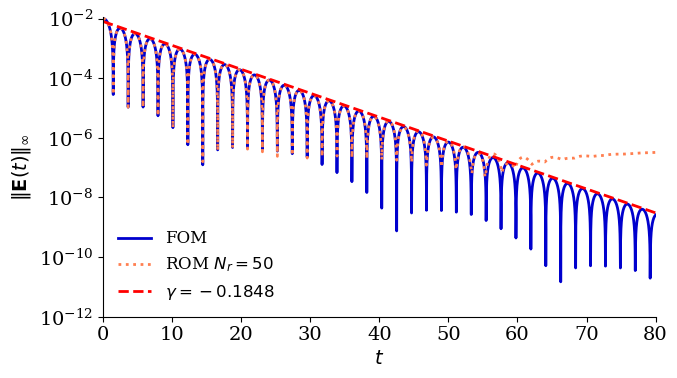

In [89]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 4))

colors = plt.cm.viridis(np.linspace(0,0.8, 3))

ax.plot(sol_midpoint_t, np.max(E_FOM, axis=0) ,c="mediumblue", linewidth=2, label=r"FOM")
ax.plot(sol_midpoint_t, np.max(E_midpoint, axis=0), ":", c="coral", linewidth=2, label="ROM $N_{r}=50$")
ax.plot(sol_midpoint_t, 0.008*np.exp(-0.1848*sol_midpoint_t), "--", linewidth=2, color="red", label=r"$\gamma = -0.1848$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\|\mathbf{E}(t)\|_{\infty}$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
ax.set_yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12])
ax.set_ylim(1e-12, 1.1e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/electric_field_damping_rate_ROM_" +str(setup.alpha_e) + "_M" + str(setup.M) + "_" + str(setup.Nr) + ".png", bbox_inches='tight', dpi=300)

# conservation laws: mass, momentum, and energy

### mass conservation

In [55]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx)\
                        +total_mass(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx)

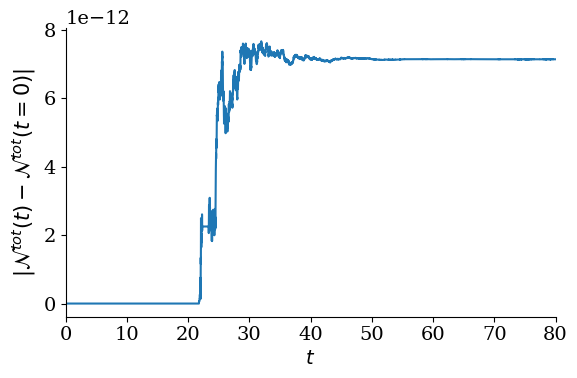

In [56]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
plt.tight_layout()

### momentum conservation

In [57]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e_midpoint[:, :, ii], alpha_s=setup.alpha_e, dx=setup.dx,
                                           m_s=setup.m_e, u_s=setup.u_e)\
                            +total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=setup.alpha_i, dx=setup.dx,
                                           m_s=setup.m_i, u_s=setup.u_i)

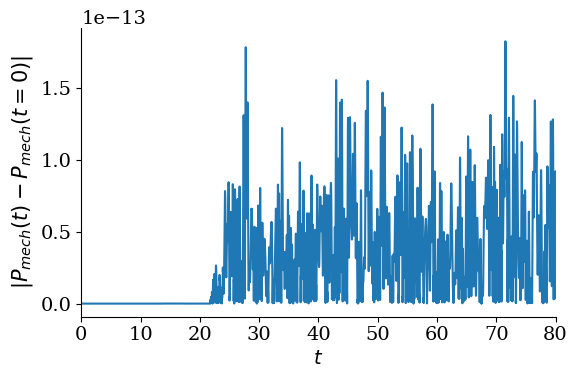

In [58]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
plt.tight_layout()

### energy conservation

In [59]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx, m_s=setup.m_e, u_s=setup.u_e)\
                           +total_energy_k(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

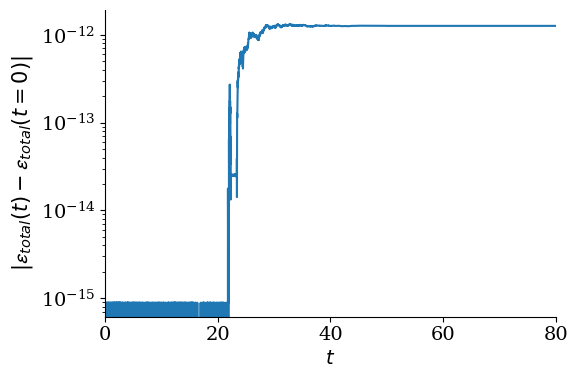

In [60]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

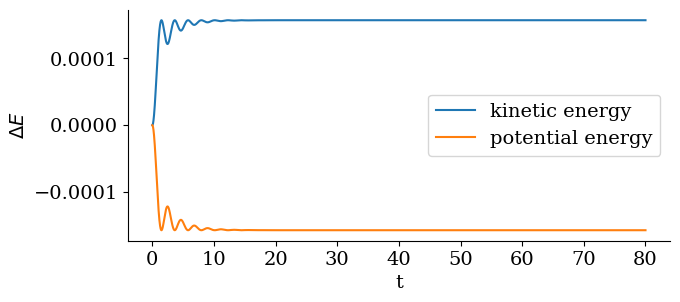

In [61]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy")
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

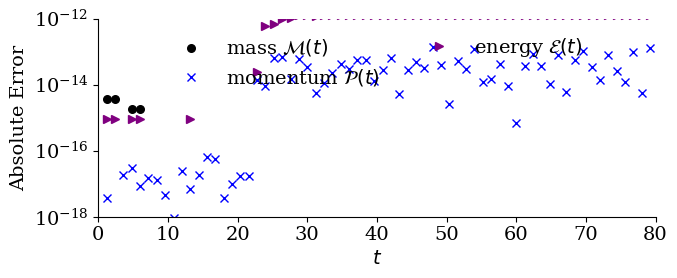

In [62]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::120], np.abs(mass_midpoint-mass_midpoint[0])[::120], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::120], np.abs(momentum_midpoint-momentum_midpoint[0])[::120], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::120], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::120], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_ylim(1e-18, 1e-12) 
ax.set_xlim(0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/conservation_" + str(setup.Nr) + "_weak_landau_ROM.png",  bbox_inches='tight', dpi=600)

## runtime, error, and efficacy comparison

### runtime comparison

In [63]:
Nr_sample = np.arange(5, 70, 5)

runtime_M3 = np.zeros(len(Nr_sample))
runtime_M4 = np.zeros(len(Nr_sample))
runtime_M5 = np.zeros(len(Nr_sample))
runtime_M6 = np.zeros(len(Nr_sample))

for ii, Nr in enumerate(Nr_sample):
    runtime_M3[ii] = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M3/sol_ROM_u_" + str(Nr) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
    runtime_M4[ii] = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M4/sol_ROM_u_" + str(Nr) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
    runtime_M5[ii] = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M5/sol_ROM_u_" + str(Nr) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
    runtime_M6[ii] = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M6/sol_ROM_u_" + str(Nr) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]

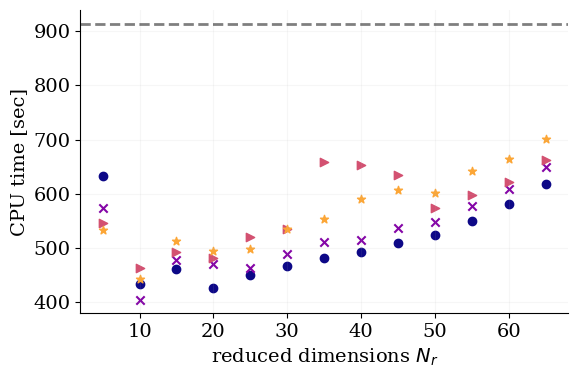

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = plt.cm.plasma(np.linspace(0,0.8,4))

ax.scatter(Nr_sample, runtime_M3, color=colors[0], marker="o")
ax.scatter(Nr_sample, runtime_M4, color=colors[1], marker="x")
ax.scatter(Nr_sample, runtime_M5, color=colors[2], marker=">")
ax.scatter(Nr_sample, runtime_M6, color=colors[3], marker="*")

runtime_fom =  np.load("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
ax.axhline(runtime_fom[0], color="black", alpha=0.5, linewidth=2, ls="--")

ax.set_ylabel("CPU time [sec]")
ax.set_xlabel("reduced dimensions $N_{r}$")
ax.grid(alpha=0.1)
ax.set_xticks([10, 20, 30,  40,50, 60])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/weak_landau_CPU_time_vs_Nr_" + str(setup.alpha_e) + ".png", bbox_inches='tight', dpi=300)

### electric field error

In [65]:
error_M3 = np.zeros(len(Nr_sample))
error_M4 = np.zeros(len(Nr_sample))
error_M5 = np.zeros(len(Nr_sample))
error_M6 = np.zeros(len(Nr_sample))

E_FOM = np.load("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/E_FOM_" + str(setup.Nv) + ".npy")

for ii, Nr in enumerate(Nr_sample):
    E_M3 = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M3/sol_ROM_E_" + str(Nr)  + ".npy")
    error_M3[ii] = np.mean(np.abs((E_FOM[1:-1, :] - E_M3[1:-1, :])/E_FOM[1:-1, :]))
    E_M4 = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M4/sol_ROM_E_" + str(Nr) + ".npy")
    error_M4[ii] = np.mean(np.abs((E_FOM[1:-1, :] - E_M4[1:-1, :])/E_FOM[1:-1, :]))
    E_M5 = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M5/sol_ROM_E_" + str(Nr) +  ".npy")
    error_M5[ii] = np.mean(np.abs((E_FOM[1:-1, :] - E_M5[1:-1, :])/E_FOM[1:-1, :]))
    E_M6 = np.load("../data/ROM/weak_landau/sample_" + str(setup.alpha_e) + "/M6/sol_ROM_E_" + str(Nr) +  ".npy")
    error_M6[ii] = np.mean(np.abs((E_FOM[1:-1, :] - E_M6[1:-1, :])/E_FOM[1:-1, :]))

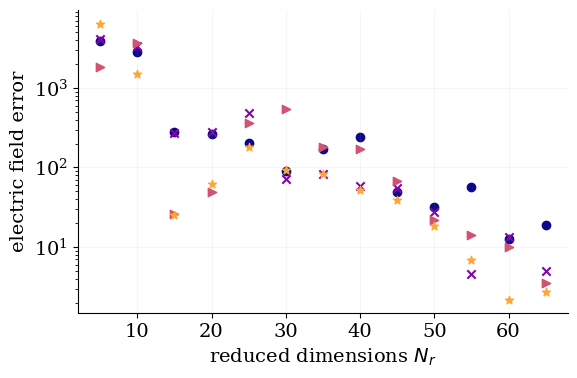

In [66]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = plt.cm.plasma(np.linspace(0,0.8,4))

ax.scatter(Nr_sample, error_M3, color=colors[0], marker="o", label="$M=3$")
ax.scatter(Nr_sample, error_M4, color=colors[1], marker="x", label="$M=4$")
ax.scatter(Nr_sample, error_M5, color=colors[2], marker=">", label="$M=5$")
ax.scatter(Nr_sample, error_M6, color=colors[3], marker="*", label="$M=6$")

# legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=13, loc='upper right')
# legend.get_frame().set_alpha(0)

ax.set_ylabel("electric field error")
ax.set_xlabel("reduced dimensions $N_{r}$")
ax.set_yscale("log")
ax.grid(alpha=0.1)
ax.set_xticks([10, 20, 30, 40, 50, 60])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/weak_landau_error_vs_Nr_" + str(setup.alpha_e) + ".png", bbox_inches='tight', dpi=300)

### efficacy

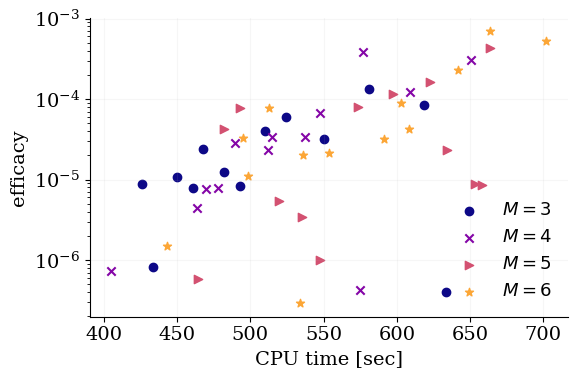

In [68]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = plt.cm.plasma(np.linspace(0,0.8,4))

ax.scatter(runtime_M3, 1/(error_M3*runtime_M3), color=colors[0], marker="o", label="$M=3$")
ax.scatter(runtime_M4, 1/(error_M4*runtime_M4), color=colors[1], marker="x", label="$M=4$")
ax.scatter(runtime_M5, 1/(error_M5*runtime_M5), color=colors[2], marker=">", label="$M=5$")
ax.scatter(runtime_M6, 1/(error_M6*runtime_M6), color=colors[3], marker="*", label="$M=6$")

legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=13, loc='lower right')
legend.get_frame().set_alpha(0)

ax.set_ylabel("efficacy")
ax.set_xlabel("CPU time [sec]")
ax.set_yscale("log")
ax.grid(alpha=0.1)
#ax.set_xticks([1000, 1200, 1400, 1600])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/weak_landau_efficacy_vs_CPU_time_" + str(setup.alpha_e) + ".png", bbox_inches='tight', dpi=300)